# **Implementation and optimization of the mean-timer technique in drift tube detectors**
##### Laboratory of Computational Physics project
##### AY 2021/2022 University of Padua

#### *Students*: Barone Francesco Pio, Valenti Lorenzo, Nagaro Gianmarco, Ninni Daniele

### **Resource 1** Animations & pictures

This is really a mess, please don't judge us. :(

In [3]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import matplotlib.colors as mc
import math
from scipy import stats
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML
#from JSAnimation.IPython_display import display_animation

source_file = '/data/Run000262/data_000000.txt'

In [2]:
# loading the dataset
data = pd.read_csv(source_file, sep=",")

def preprocess_dataset(data):
    ### dataframe preprocessing

    # detector, layer, tile
    data['detector'] = pd.Series( (data["TDC_CHANNEL"]/64).apply(np.ceil) + data["FPGA"]*2 , dtype='int')
    data['layer'] = pd.Series( data.TDC_CHANNEL%4, dtype='int')
    data['layer'].replace( {0:1, 2:2, 3:3, 1:4}, inplace=True)
    data['tile']  = pd.Series( ( ((data.TDC_CHANNEL-1)%64)/4 ).apply(np.floor) , dtype='int')
    
    # time [ns]
    t0 = data.ORBIT_CNT.min() # NOTE: because ORBIT_CNT is huge, I shift the time values by the minimum ORBIT_CNT
    data['t'] = pd.Series( (data.ORBIT_CNT-t0)*3564*25 + data.BX_COUNTER*25 + data.TDC_MEAS*25/30)

    # manage trigger hits
    data = data.rename(columns={"HEAD": "trigger"})  # since HEAD is useless, I use it as a trigger marker
    data.loc[data.TDC_CHANNEL > 128, ['detector','layer','tile']] = 0  # because these values do not make sense for triggers
    data.loc[data.TDC_CHANNEL <= 128, 'trigger'] = 0
    
    return data


data = preprocess_dataset(data)
print(f'I loaded a dataset of {len(data)} hits')

# misc
data.head(10)

I loaded a dataset of 1310592 hits


trigger  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  detector  \
0        0     1           19  1965859059        2882         5         3   
1        0     1           37  1965859067         931         1         3   
2        0     0           25  1965859082        1906        19         1   
3        0     0           25  1965859082        1916        17         1   
4        0     1           82  1965859090        3415         5         4   
5        0     0           75  1965859093        1227        17         2   
6        0     0           63  1965859094         875        24         1   
7        0     0           10  1965859101        1100         2         1   
8        0     0           47  1965859117         668         3         1   
9        0     1           74  1965859120        2465        10         4   

   layer  tile             t  
0      3     4  7.205417e+04  
1      4     9  7.360758e+05  
2      4     6  2.096966e+06  
3      4     6  2.097214e+06  
4      2     4  2.847479e+06  
5      3     2  3.060089e+06  
6      3    15  3.140395e+06  
7      2     2  3.769702e+06  
8      3    11  5.184502e+06  
9      2     2  5.496733e+06

### Animation: algorithm III

In [3]:
## animation tools

tiles = []
wrs = []
tx = []
algo_log = []
timings = []
# hit color list
color_list = ['tomato', 'orange', 'gold', 'springgreen', 'turquoise',
                      'dodgerblue', 'navy', 'mediumpurple','violet', 'hotpink',
                      'lightcoral','peru','olivedrab','indigo','magenta']
    
def algo_animation_init(title = None, note = None, focus_area = False,
              legend_primer = '"[{:03d}] {:.2f}ns ({:+.2f})".format(hit_id,time,time-first_time)', 
              legend_x_shift = 0, no_axis = 'default', show_plt = True,
              tile_edgecolor = 'dimgray', tile_linewidth = 0.7, tile_alpha = 1, override_tile_colors = None,
              wire_enable = False, wire_size = 1, wire_alpha = 1, wire_color = 'k' ):
    # This function plots the detector tiles pattern.
    #  output:     tiles     a matrix to control the properties of the tiles
    #  output:     wires     an array with the positions of the wire markers, listed by layer (1 to 4)
    
    fig = plt.figure(figsize=(10, 2), dpi=120)
    ax  = fig.add_subplot(111)
    
    # detector pattern
    dx, dy =  42, 13           # tile shape
    n_layers, n_tiles = 4, 16  # number of layers, and number of tiles per layer
    
    # hit color list
    color_list = ['tomato', 'orange', 'gold', 'springgreen', 'turquoise',
                      'dodgerblue', 'navy', 'mediumpurple','violet', 'hotpink',
                      'lightcoral','peru','olivedrab','indigo','magenta']
        
    wires = []
    tiles = []
    for jj in range(n_layers):
        row = [];
        for ii in range(n_tiles):
            t = ptc.Rectangle( (ii*dx-dx*(jj%2)/2,jj*dy), dx, dy, 
                              edgecolor=tile_edgecolor,facecolor='none',linewidth=tile_linewidth)
            ax.add_patch( t )
            row.append(t)
            wires.append( (ii*dx-dx*(jj%2)/2 + dx/2, jj*dy + dy/2) )
            #ax.text(ii*dx+dx*(jj%2)/2, jj*dy, f'{ii+1}')
        tiles.append(row)
    del row
    
    plt.xlim(-3*dx/2, dx*n_tiles + dx);    plt.ylim(-dy, dy*(n_layers+1));
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout();    ax.yaxis.set_visible(False);    #ax.xaxis.set_visible(False);
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    
    if title: plt.title(title)
    if no_axis == 'default':
        if focus_area: no_axis = True
        else: no_axis = False
    if no_axis: ax.axis('off')
    if focus_area: tiles_range = []
        
    if focus_area:  # if true, plots only the appropriate range of tiles
        plt.xlim( -3 + dx*(min(tiles_range)-1), 3 + dx*max(tiles_range) + 3*dx/2)
        plt.ylim( -dy, dy*n_layers + 5)
        if note: ax.text(3 + dx*(max(tiles_range)-2.5) + 3*dx/2, -dy/2 , note, size=8)
    else:
        if note: ax.text(0, -17, note, size=8)

    if wire_enable: plt.scatter(*zip(*wires), c=wire_color, s=wire_size, alpha=wire_alpha, zorder=2)
    return fig, tiles, wires





def algo_animation_init_timer(hit_list, timings, title = None, note = None, focus_area = False,
              legend_primer = '"[{:03d}] {:.2f}ns ({:+.2f})".format(hit_id,time,time-first_time)', 
              legend_x_shift = 0, no_axis = 'default', show_plt = True,
              tile_edgecolor = 'dimgray', tile_linewidth = 0.7, tile_alpha = 1, override_tile_colors = None,
              wire_enable = False, wire_size = 1, wire_alpha = 1, wire_color = 'k' ):
    # This function plots the detector tiles pattern.
    #  output:     tiles     a matrix to control the properties of the tiles
    #  output:     wires     an array with the positions of the wire markers, listed by layer (1 to 4)
    
    fig, ax = plt.subplots(2,1, figsize=(10, 3), dpi=120, gridspec_kw={'height_ratios': [3, 1]})
    
    # detector pattern
    dx, dy =  42, 13           # tile shape
    n_layers, n_tiles = 4, 16  # number of layers, and number of tiles per layer
    
    
    wires = []
    tiles = []
    for jj in range(n_layers):
        row = [];
        for ii in range(n_tiles):
            t = ptc.Rectangle( (ii*dx-dx*(jj%2)/2,jj*dy), dx, dy, 
                              edgecolor=tile_edgecolor,facecolor='none',linewidth=tile_linewidth)
            ax[0].add_patch( t )
            row.append(t)
            wires.append( (ii*dx-dx*(jj%2)/2 + dx/2, jj*dy + dy/2) )
            #ax.text(ii*dx+dx*(jj%2)/2, jj*dy, f'{ii+1}')
        tiles.append(row)
    del row
    
    ax[0].axis(xmin=-3*dx/2, xmax=dx*n_tiles + dx,ymin=-dy,ymax=dy*(n_layers+1));  #  plt.ylim(-dy, dy*(n_layers+1));
    ax[1].axis(xmin=min(timings)-2, xmax=max(timings)+2,ymin=-1,ymax=1);
    ax[0].set_xticks([]);  ax[0].set_yticks([]);    ax[1].set_yticks([]);
    #ax[1].axis('off')
    #ax[1].xaxis.set_visible(True)
    ax[1].axhline(y = 0, color = 'k', linewidth=1, linestyle = '-')
    plt.tight_layout()
    
    #ax[0].gca().set_aspect('equal', adjustable='box')
    #ax[0].tight_layout();    ax[0].yaxis.set_visible(False);    #ax.xaxis.set_visible(False);
    ax[1].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge are off
    ax[1].tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    if wire_enable: ax[0].scatter(*zip(*wires), c=wire_color, s=wire_size, alpha=wire_alpha, zorder=2)
    
    for idx, tt in enumerate(timings):
        ax[1].scatter(tt, 0, color=color_list[idx])
        ax[1].annotate( hit_list[idx], (tt-0.12, float(((-1)**idx)*0.6)-0.2  ) )
    return fig, ax, tiles, wires



enhanced_algorithm = False
def animate_progression(t):
    global enhanced_algorithm
    i = t*2 +1
    
    # select the mask margins:
    lma, rma = i, i+3   # active mask
    lms, rms = max(1, i-4), min(64, i+7)  # sensitivity mask

    
    # reset all the color tiles
    for tr in tiles:
        for tc in tr: tc.set( edgecolor='dimgrey', facecolor='w', linewidth=0.7, zorder=1) 
    
    if enhanced_algorithm:
        for j in range(lms,lma):
            tile_from_tdc(tiles,j).set( edgecolor='orangered', linewidth=1.4 ,zorder=2)
        for j in range(rma+1,rms+1):
            tile_from_tdc(tiles,j).set( edgecolor='orangered', linewidth=1.4,zorder=2 ) 
        for j in range(lma,rma+1):
            tile_from_tdc(tiles,j).set( edgecolor='orange', linewidth=2.8, zorder=3 )
    else:
        for j in range(lma,rma+1): 
            tile_from_tdc(tiles,j).set( edgecolor='orange', linewidth=2.5,zorder=2 )
    return []

def tdc_to_lcid(tdc):  # tdc_channel to layer-cell numeration
    layer = tdc%4;    repl = {0:1, 2:2, 3:3, 1:4};
    return [repl[layer], int( np.floor(((tdc-1)%64)/4) ) ]

def tile_from_tdc(tls,tdc):  # tdc_channel to tile object
    layer = tdc%4;    repl = {0:1, 2:2, 3:3, 1:4};
    return tls[ repl[layer] -1][ int( np.floor(((tdc-1)%64)/4) ) ]

def enable_wire( x, c = 'k', s=27, subplot=False):
    global ax
    layer = x[0];  tile = x[1];
    wire_coord = wrs[ (layer-1)*16 + tile ]
    mark_coord = ( wire_coord[0] - 0, wire_coord[1] )
    if subplot:
        return ax[0].scatter( (*mark_coord), zorder=4, c=c, marker='x', s=s)
    else:
        return plt.scatter( (*mark_coord), zorder=4, c=c, marker='x', s=s)

def init_animation( hit_list = [], title = 'Algorithm (xx)' ):
    global tiles, wrs, tx, algo_log
    fig, tiles, wrs = algo_animation_init()
    plt.title(title)
    tx = plt.text( 530, -57 , '', fontname= 'monospace', size=8)
    for hit in hit_list:  enable_wire( tdc_to_lcid(hit) )
    algo_log=''
    return fig, hit_list

def init_animation_timer( hit_list = [], timings = [], title = 'Algorithm (xx)' ):
    global tiles, wrs, tx, algo_log, ax
    fig, ax, tiles, wrs = algo_animation_init_timer(hit_list, timings)
    #ax[0].set_title(title)
    plt.suptitle(title)
    tx = ax[0].text( 500, -57 , '', fontname= 'monospace', size=8)
    for hit in hit_list:  enable_wire( tdc_to_lcid(hit), c='grey',s=15, subplot=True )
    algo_log=''
    return fig, ax, hit_list, timings

# animation function:  algoritm 1
def animate_cell_1_hits(t):
    global tiles, wrs, tx, algo_log  
    i = t*2 +1
    
    # select the mask margins:
    lma, rma = i, i+3   # active mask
    
    # reset all the color tiles
    for tr in tiles:
        for tc in tr: tc.set( edgecolor='dimgrey', facecolor='w', linewidth=0.7 ) 
    
    for j in range(lma,rma+1): tile_from_tdc(tiles,j).set( edgecolor='orange', linewidth=2.5,zorder=2 )
    
    # counting events in mask
    count = 0
    indic = []
    for hit in hit_list:
        if hit in range(lma,rma+1):
            tile_from_tdc(tiles,hit).set( facecolor='khaki' )
            indic.append(hit)
            count += 1

    if count == 0:  xtext= f'step {t}  ->  {count} hits in mask (continue)'
    elif count < 3: xtext= f'step {t}  ->  {count} hits in mask (reject)'
    elif count < 5:
        xtext= f'step {t}  ->  {count} hits in mask (keep it as an event)'
        algo_log += f'event found in [{indic}]\n'
    else:           xtext= f'step {t}  ->  {count} hits in mask (reject)'
    
    plt.xlabel(xtext, horizontalalignment='left', x= 0.05)
    tx.set(text = algo_log)
    return []

# animation function:  algoritm II
def animate_cell_2_hits(t):
    global algo_log
    
    i = t*2 +1
    
    # select the mask margins:
    lma, rma = i, i+3   # active mask
    lms, rms = max(1, i-4), min(64, i+7)  # sensitivity mask
    
    # reset all the color tiles
    for tr in tiles:
        for tc in tr: tc.set( edgecolor='dimgrey', facecolor='w', linewidth=0.7 ) 
    
    for j in range(lms,lma):
        tile_from_tdc(tiles,j).set( edgecolor='orangered', linewidth=1.4 ,zorder=2)
    for j in range(rma+1,rms+1):
        tile_from_tdc(tiles,j).set( edgecolor='orangered', linewidth=1.4,zorder=2 ) 
    for j in range(lma,rma+1):
        tile_from_tdc(tiles,j).set( edgecolor='orange', linewidth=2.8, zorder=3 )
    
    # counting events in mask
    count = 0;   indic = [];  reject = False;
    for hit in hit_list:
        if hit in range(lma,rma+1):
            tile_from_tdc(tiles,hit).set( facecolor='khaki' )
            indic.append(hit)
            count += 1
        elif hit in range(lms,rms+1):
            tile_from_tdc(tiles,hit).set( facecolor='lightsalmon' )
            #indic.append(hit)
            reject = True
        
    
    if count == 0:   xtext= f'step {t}  ->  {count} hits in mask (continue)'
    elif count < 3:  xtext= f'step {t}  ->  {count} hits in mask (reject)'
    elif count < 5:
        if reject:
            xtext= f'step {t}  ->  {count} hits in mask, but the event is not clear (reject)'
            algo_log += f'  rejecting [{indic}]\n'
        else:
            xtext= f'step {t}  ->  {count} hits in mask (accept as event)'
            algo_log += f'event found in [{indic}]\n'
    else:            xtext= f'step {t}  ->  {count} hits in mask (reject)'
    
    plt.xlabel(xtext, horizontalalignment='left', x= 0.05)
    tx.set(text = algo_log)
    return []


# animation function:  algoritm III
def animate_cell_3_hits(t):
    global algo_log
    global timings
    global ax
    global plot_masks
    
    i = (10)*2 +1 # fix the masking
    # select the mask margins:
    lma, rma = i, i+3   # active mask
    lms, rms = max(1, i-4), min(64, i+7)  # sensitivity mask
    
    for idx, tt in enumerate(timings):
        if t == int(tt):
            enable_wire( tdc_to_lcid(hit_list[idx]), subplot=True, c=color_list[idx])
            
    
    # reset all the color tiles
    for tr in tiles:
        for tc in tr: tc.set( edgecolor='dimgrey', facecolor='w', linewidth=0.7 ) 
        
    if plot_masks:
        for j in range(lms,lma):
            tile_from_tdc(tiles,j).set( edgecolor='orangered', linewidth=1.4 ,zorder=2)
        for j in range(rma+1,rms+1):
            tile_from_tdc(tiles,j).set( edgecolor='orangered', linewidth=1.4,zorder=2 ) 
        for j in range(lma,rma+1):
            tile_from_tdc(tiles,j).set( edgecolor='orange', linewidth=2.8, zorder=3 )
    
    # counting events in mask
    #count = 0;   indic = [];  reject = False;   dt=4
    #prev_time = 0
    #for idx, hit in enumerate(hit_list):
    #    if (timings[idx] <= t) and (timings[idx] - prev_time < dt): # after the event hits
            
    #        if hit in range(lma,rma+1):
    #            tile_from_tdc(tiles,hit).set( facecolor='khaki' )
    #            indic.append(hit)
    #            count += 1
    #        elif hit in range(lms,rms+1):
    #            tile_from_tdc(tiles,hit).set( facecolor='lightsalmon' )
    #            #indic.append(hit)
    #            reject = True
    #        prev_time = timings[idx]
        
    
    #if count == 0:   xtext= f'step {t}  ->  {count} hits in mask (continue)'
    #elif count < 3:  xtext= f'step {t}  ->  {count} hits in mask (reject)'
    #elif count < 5:
    #    if reject:
    #        xtext= f'step {t}  ->  {count} hits in mask, but the event is not clear (reject)'
    #        algo_log += f'  rejecting [{indic}]\n'
    #    else:
    #        xtext= f'step {t}  ->  {count} hits in mask (accept as event)'
    #        algo_log += f'event found in [{indic}]\n'
    #else:            xtext= f'step {t}  ->  {count} hits in mask (reject)'
    
    ax[1].set_xlabel(f't = {t}', horizontalalignment='left', x= 0.05)
    #tx.set(text = algo_log)
    fig.subplots_adjust(bottom=0.3)
    return []

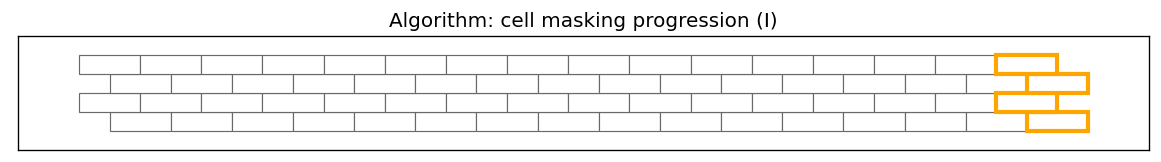

In [4]:
## ANIMATION:    Algo I mask progression
enhanced_algorithm = False
fig, tiles, wrs , = algo_animation_init()
plt.title('Algorithm: cell masking progression (I)')
anim = animation.FuncAnimation(fig, animate_progression,  frames=31, interval=400, blit=True)
display(HTML(anim.to_jshtml()))

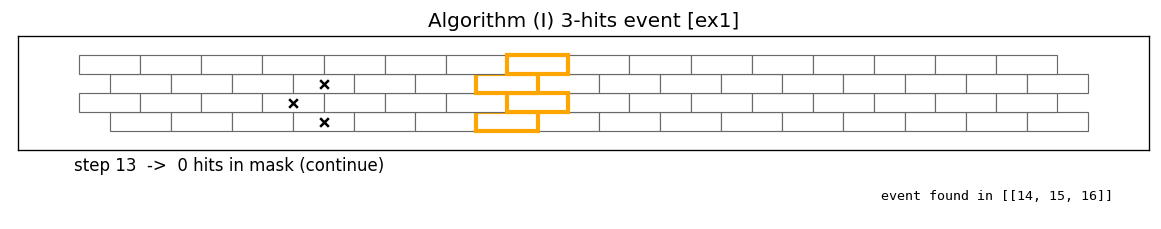

In [5]:
## ANIMATION:    Algo I + sample hits (3 hit event)
fig, hit_list = init_animation( hit_list = [ 14, 15, 16], title = 'Algorithm (I) 3-hits event [ex1]' )
anim = animation.FuncAnimation(fig, animate_cell_1_hits, frames=14, interval=700, blit=True)
display(HTML(anim.to_jshtml()))

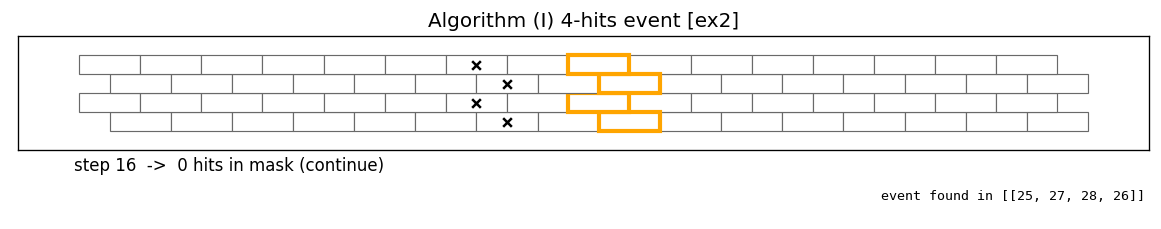

In [6]:
## ANIMATION:    Algo I + sample hits (4 hit event)
fig, hit_list = init_animation( hit_list = [25, 27, 28, 26], title = 'Algorithm (I) 4-hits event [ex2]' )
anim = animation.FuncAnimation(fig, animate_cell_1_hits, frames=17, interval=500, blit=True)
display(HTML(anim.to_jshtml()))

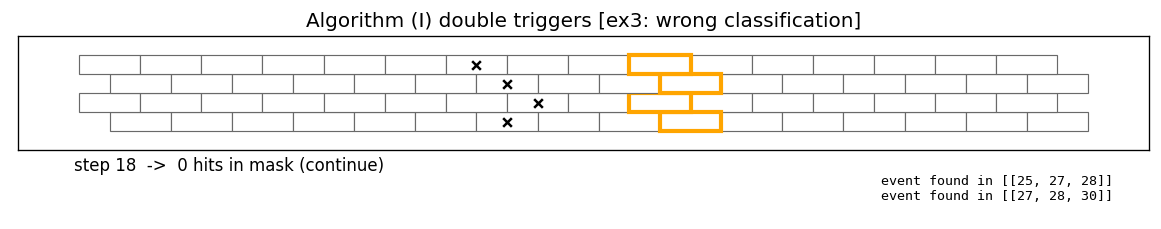

In [7]:
## ANIMATION:    Algo I + sample hits (error case)
fig, hit_list = init_animation( hit_list = [25,27,28,30], title = 'Algorithm (I) double triggers [ex3: wrong classification]' )
anim = animation.FuncAnimation(fig, animate_cell_1_hits, frames=19, interval=500, blit=True)
display(HTML(anim.to_jshtml()))

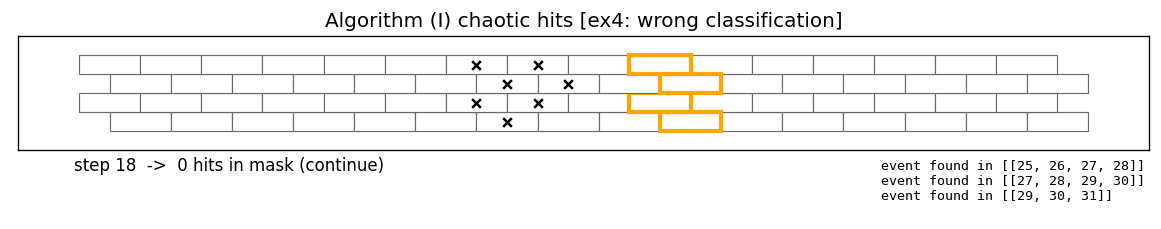

In [8]:
## ANIMATION:    Algo II + sample hits (error case)
fig, hit_list = init_animation( hit_list =  [25,26,27,28,29,30,31], title = 'Algorithm (I) chaotic hits [ex4: wrong classification]' )
anim = animation.FuncAnimation(fig, animate_cell_1_hits, frames=19, interval=500, blit=True)
display(HTML(anim.to_jshtml()))

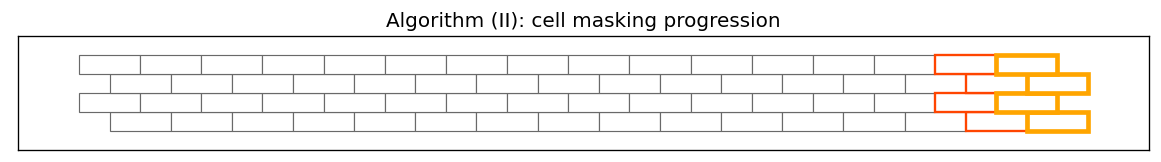

In [9]:
## ANIMATION:    Algo II masking
enhanced_algorithm = True
fig, tiles, wrs , = algo_animation_init()
plt.title('Algorithm (II): cell masking progression')
anim = animation.FuncAnimation(fig, animate_progression,  frames=31, interval=400, blit=True)
display(HTML(anim.to_jshtml()))

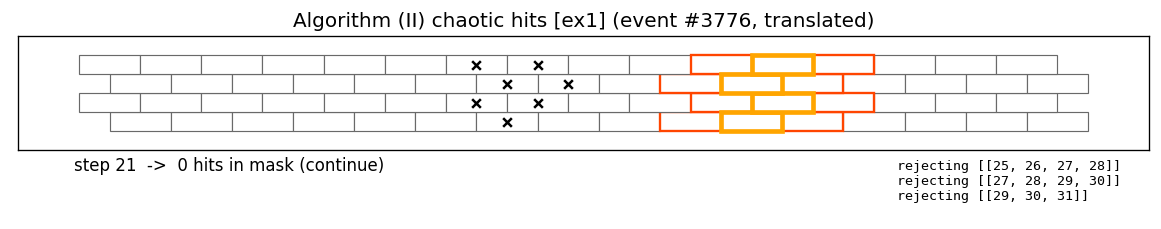

In [10]:
## ANIMATION:    Algo II + sample hits (solving error)   (event #3776 translated)
fig, hit_list = init_animation( hit_list = [25,26,27,28,29,30,31], title = 'Algorithm (II) chaotic hits [ex1] (event #3776, translated)' )
anim = animation.FuncAnimation(fig, animate_cell_2_hits, frames=22, interval=500, blit=True)
display(HTML(anim.to_jshtml()))

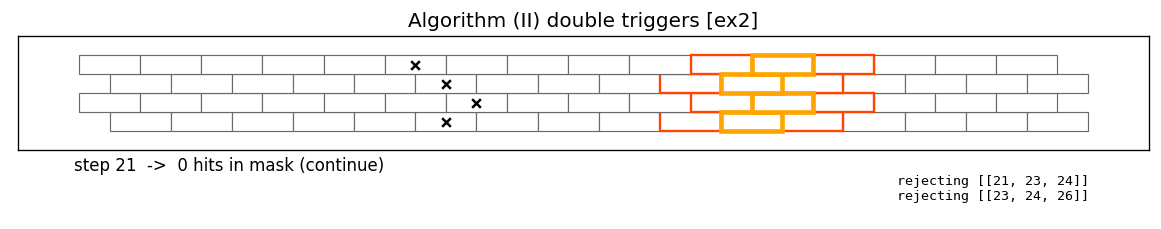

In [11]:
## ANIMATION:    Algo II + sample hits (undesired pattern)
fig, hit_list = init_animation( hit_list=[21,23,24,26], title = 'Algorithm (II) double triggers [ex2]' )
anim = animation.FuncAnimation(fig, animate_cell_2_hits, frames=22, interval=500, blit=True)
display(HTML(anim.to_jshtml()))

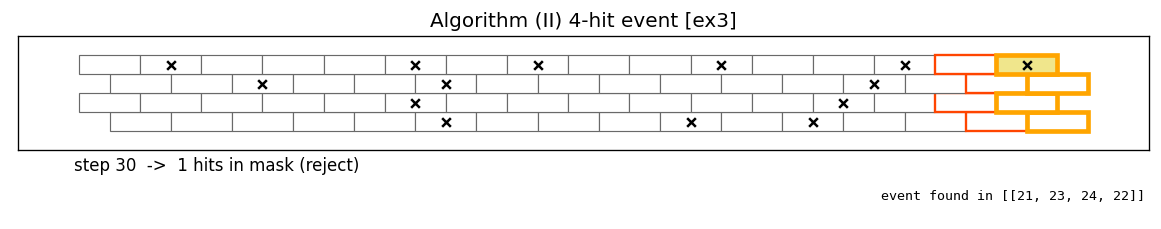

In [12]:
## ANIMATION:    Algo II + sample hits
fig, hit_list = init_animation( hit_list=[5,21,23,24,22,11,29,40,41,48,50,51,53,61], title = 'Algorithm (II) 4-hit event [ex3]' )
anim = animation.FuncAnimation(fig, animate_cell_2_hits, frames=31, interval=500, blit=True)
display(HTML(anim.to_jshtml()))

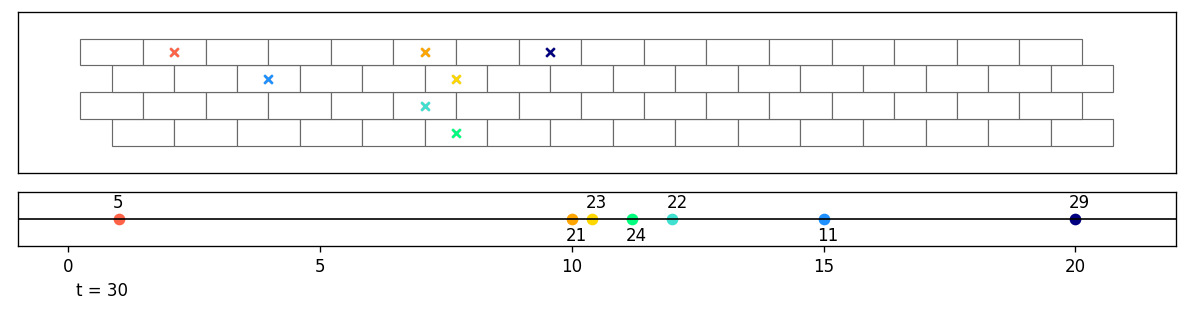

In [13]:
## ANIMATION:    Algo III timing
plot_masks = False
fig, ax, hit_list, timings = init_animation_timer( hit_list=[5,21,23,24,22,11,29],
                                timings=[1,10,10.4,11.2,12,15,20],
                                title = '' )
anim = animation.FuncAnimation(fig, animate_cell_3_hits, frames=31, interval=300, blit=True)
display(HTML(anim.to_jshtml()))

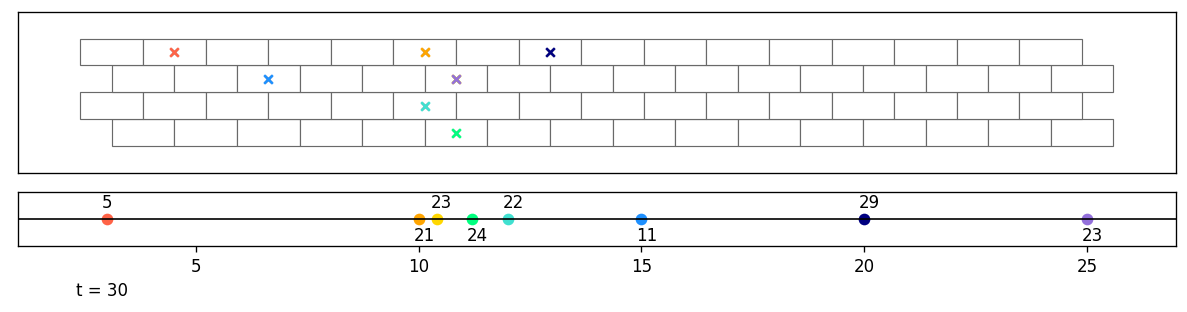

In [14]:
## ANIMATION:    Algo III timing
plot_masks = False
fig, ax, hit_list, timings = init_animation_timer( hit_list=[5,21,23,24,22,11,29,23],
                                timings=[3,10,10.4,11.2,12,15,20,25],
                                title = '' )
anim = animation.FuncAnimation(fig, animate_cell_3_hits, frames=31, interval=300, blit=True)
display(HTML(anim.to_jshtml()))

http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

### DRAFT

In [7]:
def plot_hits( title = None, note = None, focus_area = False,
              legend_primer = '"[{:03d}] {:.2f}ns ({:+.2f})".format(hit_id,time,time-first_time)', 
              legend_x_shift = 0, no_axis = 'default', show_plt = True,
              tile_edgecolor = 'dimgray', tile_linewidth = 0.7, tile_alpha = 1, override_tile_colors = None,
              wire_enable = False, wire_size = 1, wire_alpha = 1, wire_color = 'k' ):
    # This function plots the detector tiles pattern and marks with colors the tiles which register a hit.
    #  input:  hit_list    a list of hits, for instance:  [ (31, 14696.6, 1, 13), (29, 14645.0, 2, 13) ]
    #                           -> each hit is a tuple containing ( HIT_ID, time [ns], layer, tile )
    #     optional:
    #          focus_area     (False)   if True restricts the are of the plot to the zone of detector
    #                                     which is affected by hits
    #          legend_primer  (format)  set the format of the legend
    #                                     -> use 'None' to disable legend
    #                                     -> available variables:   hit_id, time, prev_time, layer, tile, idx
    #          note           (None)    if there is some text, adds it in lower left side of the plot
    #                                     note: do not use it with limited_area = True
    #          ...      the other parameters change the aesthetis of the plot
    #
    #  output:   tiles     a matrix to control the properties of the tiles
    
    fig = plt.figure(figsize=(10, 2), dpi=120)
    ax  = fig.add_subplot(111)
    
    # detector pattern
    dx, dy =  42, 13           # tile shape
    n_layers, n_tiles = 4, 16  # number of layers, and number of tiles per layer
    
    wires = [];  tiles = [];
    for jj in range(n_layers):
        row = [];
        for ii in range(n_tiles):
            t = ptc.Rectangle( (ii*dx-dx*(jj%2)/2,jj*dy), dx, dy, 
                              edgecolor=tile_edgecolor,facecolor='none',linewidth=tile_linewidth)
            ax.add_patch( t )
            row.append(t)
            wires.append( (ii*dx-dx*(jj%2)/2 + dx/2, jj*dy + dy/2) )
            ax.text(ii*dx-dx*(jj%2)/2 +dx/2,jj*dy+2, f'{ii}',ha='center',size=8.5, fontfamily='monospace')
        tiles.append(row)
    del row
    
    plt.xlim(-3*dx/2, dx*n_tiles + dx);    plt.ylim(-dy*5, dy*n_layers + 5);
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout();    ax.xaxis.set_visible(False);    ax.yaxis.set_visible(False);
    
    if title: plt.title(title)
    if no_axis == 'default':
        if focus_area: no_axis = True
        else: no_axis = False
    ax.axis('off')
    if focus_area: tiles_range = []
    
    if wire_enable: plt.scatter(*zip(*wires), c=wire_color, s=wire_size, alpha=wire_alpha, zorder=2)
    #if show_plt: plt.show()
    return tiles, wires

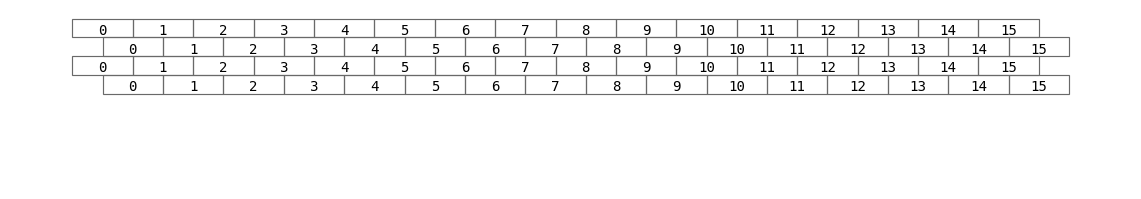

In [8]:
plot_hits()
plt.savefig('../img/pattern_new.png')

In [5]:
def plot_hits( title = None, note = None, focus_area = False,
              legend_primer = '"[{:03d}] {:.2f}ns ({:+.2f})".format(hit_id,time,time-first_time)', 
              legend_x_shift = 0, no_axis = 'default', show_plt = True,
              tile_edgecolor = 'dimgray', tile_linewidth = 0.7, tile_alpha = 1, override_tile_colors = None,
              wire_enable = False, wire_size = 1, wire_alpha = 1, wire_color = 'k' ):
    # This function plots the detector tiles pattern and marks with colors the tiles which register a hit.
    #  input:  hit_list    a list of hits, for instance:  [ (31, 14696.6, 1, 13), (29, 14645.0, 2, 13) ]
    #                           -> each hit is a tuple containing ( HIT_ID, time [ns], layer, tile )
    #     optional:
    #          focus_area     (False)   if True restricts the are of the plot to the zone of detector
    #                                     which is affected by hits
    #          legend_primer  (format)  set the format of the legend
    #                                     -> use 'None' to disable legend
    #                                     -> available variables:   hit_id, time, prev_time, layer, tile, idx
    #          note           (None)    if there is some text, adds it in lower left side of the plot
    #                                     note: do not use it with limited_area = True
    #          ...      the other parameters change the aesthetis of the plot
    #
    #  output:   tiles     a matrix to control the properties of the tiles
    
    fig = plt.figure(figsize=(10, 2), dpi=120)
    ax  = fig.add_subplot(111)
    
    # detector pattern
    dx, dy =  42, 13           # tile shape
    n_layers, n_tiles = 4, 16  # number of layers, and number of tiles per layer
    
    wires = [];  tiles = [];
    for jj in range(n_layers):
        row = [];
        for ii in range(n_tiles):
            t = ptc.Rectangle( (ii*dx-dx*(jj%2)/2,jj*dy), dx, dy, 
                              edgecolor=tile_edgecolor,facecolor='none',linewidth=tile_linewidth)
            ax.add_patch( t )
            row.append(t)
            wires.append( (ii*dx-dx*(jj%2)/2 + dx/2, jj*dy + dy/2) )
            lay_map = { 1: 0, 2:2, 3:1, 4:3 }
            this_tdc = (ii+1)*4 - lay_map[jj+1]

            ax.text(ii*dx-dx*(jj%2)/2 +dx/2,jj*dy+2, f'{this_tdc}',ha='center',size=8.5, fontfamily='monospace')
        tiles.append(row)
    del row
    
    plt.xlim(-3*dx/2, dx*n_tiles + dx);    plt.ylim(-dy*5, dy*n_layers + 5);
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout();    ax.xaxis.set_visible(False);    ax.yaxis.set_visible(False);
    
    if title: plt.title(title)
    if no_axis == 'default':
        if focus_area: no_axis = True
        else: no_axis = False
    ax.axis('off')
    if focus_area: tiles_range = []
    
    if wire_enable: plt.scatter(*zip(*wires), c=wire_color, s=wire_size, alpha=wire_alpha, zorder=2)
    #if show_plt: plt.show()
    return tiles, wires

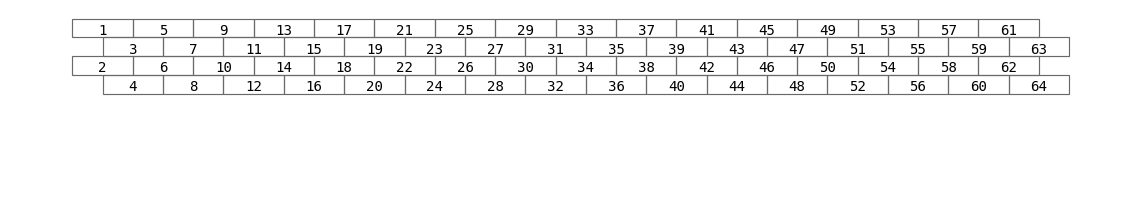

In [6]:
plot_hits()
plt.savefig('../img/pattern_tdc.png')

End of file.